# AIFFELTHON -  [WONJIN]

In [ ]:
import numpy as np # linear algebra
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import librosa, librosa.display 
import librosa as lb
import nlpaug.augmenter.audio as naa
from nlpaug.util.audio.visualizer import AudioVisualizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import Audio
import os
import tensorflow_io as tfio
from scipy import signal
from scipy.signal import butter, freqz, filtfilt, find_peaks 
import random
import soundfile as sf

root = '/content/drive/MyDrive/hacker/aiffelthon/aiffelthon'
sr = 16000

In [ ]:
#위에서 패딩 및 컷팅한 작업을 새로운 데이터프레임으로 생성하여 data2로 지정함
data2 = pd.read_csv('/content/drive/MyDrive/hacker/aiffelthon/aiffelthon/no_zeropadding.csv')
data2.head()

,Unnamed: 0,start,end,pid,mode,filename,disease,crack_wheeze
0,0,1.862,5.718,160,mc,160_1b3_Ar_mc_AKGC417L_0.wav,COPD,2
1,1,5.718,9.725,160,mc,160_1b3_Ar_mc_AKGC417L_1.wav,COPD,2
2,2,9.725,13.614,160,mc,160_1b3_Ar_mc_AKGC417L_2.wav,COPD,2
3,3,13.614,17.671,160,mc,160_1b3_Ar_mc_AKGC417L_3.wav,COPD,2
4,4,17.671,19.541,160,mc,160_1b3_Ar_mc_AKGC417L_4.wav,COPD,0


In [ ]:
data2.drop(['Unnamed: 0'], axis = 1)

,start,end,pid,mode,filename,disease,crack_wheeze
0,1.862,5.718,160,mc,160_1b3_Ar_mc_AKGC417L_0.wav,COPD,2
1,5.718,9.725,160,mc,160_1b3_Ar_mc_AKGC417L_1.wav,COPD,2
2,9.725,13.614,160,mc,160_1b3_Ar_mc_AKGC417L_2.wav,COPD,2
3,13.614,17.671,160,mc,160_1b3_Ar_mc_AKGC417L_3.wav,COPD,2
4,17.671,19.541,160,mc,160_1b3_Ar_mc_AKGC417L_4.wav,COPD,0
...,...,...,...,...,...,...,...
6893,9.393,11.764,159,sc,159_1b1_Pr_sc_Meditron_4.wav,Healthy,0
6894,11.764,14.050,159,sc,159_1b1_Pr_sc_Meditron_5.wav,Healthy,0
6895,14.050,16.521,159,sc,159_1b1_Pr_sc_Meditron_6.wav,Healthy,0
6896,16.521,18.907,159,sc,159_1b1_Pr_sc_Meditron_7.wav,Healthy,0


## Smart_padding augmentation :
같은 patient_id(pid)에서 클래스가 같은 것 끼리 붙여서 7초로 만드는 작업을 수행함.

1) normal + normal

2) crackle + crackle / crackle + normal

3) wheezig + wheezing / wheezing + normal

4) both + both / both + normal

위의 4가지의 작업을 수행하고 numpy.concat을 수행한 후 maxLen (7초가)되지 않을 경우 길이를 확인하여 앞에서 concat한 부분을 한 번더 붙이고 7초로 자르는 작업을 수행함.



In [ ]:
test_root = '/content/drive/MyDrive/AIFFEL/test_root/'

In [ ]:
def check_length(audio, maxLen):
  if len(audio)/16000 > maxLen:
    audio = audio_slicing(audio)
    return test.append(audio)
  else:
    new = np.concatenate([audio,audio])
    return check_length(new, maxLen)

def audio_slicing(signal, max = 7 * sr):
  if len(signal) > max:
    return signal[:max]
  else:
    return signal          

In [ ]:
filename2 = []
start2 = []
end2 = []
pid2 = []
mode2 = []
crack_wheeze2 = []

test = []
idx=0
maxLen = 7

current_row = data2.loc[0]

for idx, row in data2.iterrows():
  start = row.start
  end = row.end
  pid = row.pid
  filename = row.filename
  mode = row.mode
  crack_wheeze = row.crack_wheeze

  if idx == 6897:
    break

  elif current_row.pid == row.pid:

    # normal + normal
    if current_row.crack_wheeze == 0 and row.crack_wheeze == 0:
      sample_i,_ = librosa.load(path2 + current_row.filename, sr=sr)
      sample_j,_ = librosa.load(path2 + row.filename, sr=sr)
      new_sample = np.concatenate([sample_i, sample_j])

    # crackle + crackle
    elif current_row.crack_wheeze == 1 and row.crack_wheeze == 1:
      sample_i,_ = librosa.load(path2 + current_row.filename, sr=sr)
      sample_j,_ = librosa.load(path2 + row.filename, sr=sr)
      new_sample = np.concatenate([sample_i, sample_j])

    # crackle + normal  
    elif current_row.crack_wheeze == 1 and row.crack_wheeze == 0:
      sample_i,_ = librosa.load(path2 + current_row.filename, sr=sr)
      sample_j,_ = librosa.load(path2 + row.filename, sr=sr)
      new_sample = np.concatenate([sample_i, sample_j])

    # wheezing + wheezing  
    elif current_row.crack_wheeze == 2 and row.crack_wheeze == 2:
      sample_i,_ = librosa.load(path2 + current_row.filename, sr=sr)
      sample_j,_ = librosa.load(path2 + row.filename, sr=sr)
      new_sample = np.concatenate([sample_i, sample_j])

    # wheezing + normal
    elif current_row.crack_wheeze == 2 and row.crack_wheeze == 0:
      sample_i,_ = librosa.load(path2 + current_row.filename, sr=sr)
      sample_j,_ = librosa.load(path2 + row.filename, sr=sr)
      new_sample = np.concatenate([sample_i, sample_j])

    # both + both
    elif current_row.crack_wheeze == 3 and row.crack_wheeze == 3:
      sample_i,_ = librosa.load(path2 + current_row.filename, sr=sr)
      sample_j,_ = librosa.load(path2 + row.filename, sr=sr)
      new_sample = np.concatenate([sample_i, sample_j])

    # both + normal
    elif current_row.crack_wheeze == 3 and row.crack_wheeze == 0:
      sample_i,_ = librosa.load(path2 + current_row.filename, sr=sr)
      sample_j,_ = librosa.load(path2 + row.filename, sr=sr)
      new_sample = np.concatenate([sample_i, sample_j])

    current_row = row

  else:
    current_row = row

  if check_data > maxLen:
    new_sample = audio_slicing(new_sample)
    test.append(new_sample)
     # maxLen 이 안되는 경우 check_length의 else부분에서 input로 concat한 new_sampel이 들어가고 그 것을 한 번더 붙이는 과정이 반복됨.
  else:
    check_length(new_sample, maxLen) 


  filename = filename [:-5] + str(idx) + '.wav'


  filename2.append(filename)
  start2.append(start)
  end2.append(end)
  pid2.append(pid)
  mode2.append(mode)
  crack_wheeze2.append(crack_wheeze)

  sf.write(file = test_root + filename, data = test[idx], samplerate=sr)

  # if len(test) % 100 ==0:
  #   print(len(test))


In [ ]:
# pid다르게 하여 waveplot출력해보기

pid_101 = '/content/drive/MyDrive/AIFFEL/test_root/101_1b1_Al_sc_Meditron_13559.wav'
pid_107 = '/content/drive/MyDrive/AIFFEL/test_root/107_2b4_Ll_mc_AKGC417L_3726.wav'

sample_101,_ = librosa.load(pid_101,sr=sr)
sample_107,_ = librosa.load(pid_107,sr=sr)

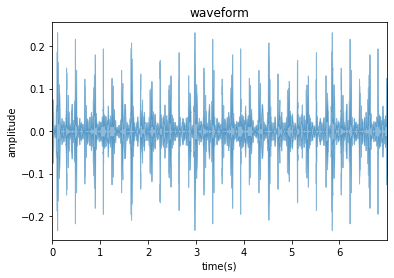

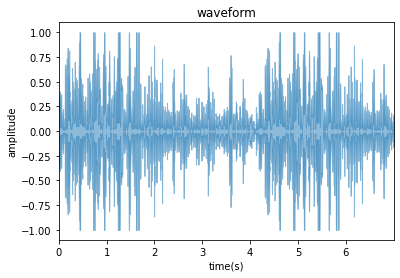

In [ ]:
librosa.display.waveplot(sample_101, sr=sr, alpha = 0.5)
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.title("waveform")
plt.show()

librosa.display.waveplot(sample_107, sr=sr, alpha = 0.5)
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.title("waveform")
plt.show()